# 1. Ground true

## Import

* import numpy for matrix
* import matplotlib.pyplot for plotting
* import math for math function
* import random for random variable. Creating noise or start point etc

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math
import random

## Init constant value

In [2]:
objectNum = 5

startTime_Sec = 0
endTime_Sec = 10
dtObject = 0.005 # 5ms
dtLidar = 0.025 # 25ms
dtRadar = 0.050 # 50ms

TRAJECTORY = 1
X = 2
Y = 3

LidarNoiseSize = 5

## Const accelerate equation

In [3]:
class Trajectory():
    def __init__ (self, times):
        self.x = np.zeros_like(times)
        self.y = np.zeros_like(times)
        
        self.rho = np.zeros_like(times)
        self.phi = np.zeros_like(times)
    
class Object():
    #def __init__ (self, times, x, y, ID, color):
        #self.color = color
    def __init__ (self, times, x, y, ID):
        self.ID = ID
        self.states = []
        self.trajectory = Trajectory(times)
        
        #state: x, y, x`, y`, x``, y``
        self.state_ca = np.matrix([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).T

        self.state_ca[0] = x
        self.state_ca[1] = y

        self.F = np.matrix([[1.0, 0.0, dtObject, 0.0, 1/2.0*dtObject**2, 0.0],
                         [0.0, 1.0, 0.0, dtObject, 0.0, 1/2.0*dtObject**2],
                         [0.0, 0.0, 1.0, 0.0, dtObject, 0.0],
                         [0.0, 0.0, 0.0, 1.0, 0.0, dtObject],
                         [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        
        self.B = np.matrix([[0.0, 0.0],
                           [0.0, 0.0],
                           [0.0, 0.0],
                           [0.0, 0.0],
                           [1.0, 0.0],
                           [0.0, 1.0]])
    
    def getState(self, ax, ay):
        accel = np.matrix([ax, ay]).T
        self.state_ca = self.F*self.state_ca + self.B*accel
        
        return self.state_ca
        
        
    def subplots(self, times, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, label='Ground truth{0}'.format(ID))
        axes[1].plot (times, self.trajectory.x, label='Ground truth{0}'.format(ID))
        axes[2].plot (times, self.trajectory.y, label='Ground truth{0}'.format(ID))
        
        
    def plot (self, times, ID, pltType):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, color="red", linewidth=1.5, linestyle="--",label="Ground truth {0}".format(ID))
                
        elif pltType == X:
            plt.plot(times, self.trajectory.x, color="red", linewidth=1.5, linestyle="--",label="Ground truth {0}".format(ID))
                
        elif pltType == Y:
            plt.plot(times, self.trajectory.y, color="red", linewidth=1.5, linestyle="--",label="Ground truth {0}".format(ID))

## Creating object and getting object states

In [4]:
objects = []
times = np.linspace (startTime_Sec, endTime_Sec, int(endTime_Sec/dtObject))

# create object with random position
for objectIdx in range(objectNum):
    x = random.uniform(0.0, 1000.0)
    y = random.uniform(0.0, 1000.0)
    
    object = Object(times, x, y, objectIdx)
    objects.append(object)


# get object state
for objectIdx, object in enumerate(objects):
    for t in range(len(times)):
        accel = 0.0
        radian = 0.0
    
        if (t % 5) == 0:
            accel = random.uniform(-10.0, 10.0)
            radian = random.uniform(-math.pi, math.pi)
        
        state = object.getState(accel*math.cos(radian), accel*math.sin(radian))

        object.states.append(state)
        object.trajectory.x[t] = state[0, 0]
        object.trajectory.y[t] = state[1, 0]

## Plotting object trajectory and x, y

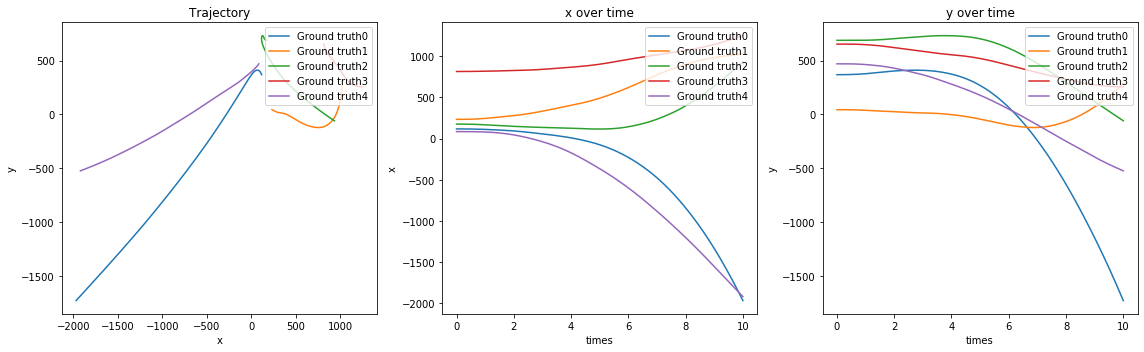

In [5]:
fig, axes = plt.subplots(1, 3, figsize = (16, 5))

for objectIdx, object in enumerate (objects):
    object.subplots (times, axes, objectIdx)
    
    axes[0].legend(loc="upper right")
    axes[0].set(xlabel = 'x', ylabel = 'y')
    axes[0].set_title('Trajectory')
    
    axes[1].legend(loc="upper right")
    axes[1].set(xlabel = 'times', ylabel = 'x')
    axes[1].set_title('x over time')
    
    axes[2].legend(loc="upper right")
    axes[2].set(xlabel = 'times', ylabel = 'y')
    axes[2].set_title('y over time')
    
plt.tight_layout()

# 2. Sensor model

### 2.1 lidar model

In [6]:
class LiDAR():
    def __init__(self, times):
        self.measurements = []
        self.trajectory = Trajectory(times)
        self.H = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                           [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]])
            
            
    def measure(self, states):
        measurementIdx = 0
        
        for stateIdx, state in enumerate(states):
            
            # 25ms 
            if (stateIdx % (dtLidar/dtObject)) == 0:
                #measurement = self.H*state + self.R
                measurement = self.H*state

                # Noise
                sensor_noise = np.random.randn()*LidarNoiseSize
                measurement[0, 0] = measurement[0, 0] + sensor_noise
                
                sensor_noise = np.random.randn()*LidarNoiseSize
                measurement[1, 0] = measurement[1, 0] + sensor_noise
                
                self.measurements.append(measurement)
                self.trajectory.x[measurementIdx] = measurement[0, 0]
                self.trajectory.y[measurementIdx] = measurement[1, 0]
                
                measurementIdx = measurementIdx + 1
                
            else:
                continue
                
                
    def subplots(self, times, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, label='Lidar{0}'.format(ID))
        axes[1].plot (times, self.trajectory.x, label='Lidar{0}'.format(ID))
        axes[2].plot (times, self.trajectory.y, label='Lidar{0}'.format(ID))
    
    
    def plot (self, times, ID, pltType):
        if pltType == TRAJECTORY:
            plt.plot(self.trajectory.x, self.trajectory.y, color="blue", linewidth=0.5, linestyle="-",label="Lidar {0}".format(ID))
                
        elif pltType == X:
            plt.plot(times, self.trajectory.x, color="blue", linewidth=0.5, linestyle="-",label="Lidar {0}".format(ID))
                
        elif pltType == Y:
            plt.plot(times, self.trajectory.y, color="blue", linewidth=0.5, linestyle="-",label="Lidar {0}".format(ID))

### 2.2 Radar model

In [7]:
class Radar():
    def __init__(self, times):
        self.measurements = []
        self.trajectory = Trajectory(times)

    def measure(self, states):
        for stateIdx, state in enumerate(states):
            measurementIdx = 0
            
            # 50ms
            if (stateIdx % (dtRadar/dtObject)) == 0:
                measurement = []
                rho = math.sqrt(math.pow(state[0, 0], 2) + math.pow(state[1, 0], 2))
                phi = math.atan2(state[1, 0], state[0, 0])
                rhoRate = (state[0, 0]*state[2, 0] + state[1, 0]*state[3, 0])/rho
                
                measurement.append(rho)
                measurement.append(phi)
                measurement.append(rhoRate)
                
                self.measurements.append(measurement)
                self.trajectory.rho[measurementIdx] = measurement[0]
                self.trajectory.phi[measurementIdx] = measurement[1]
                
                measurementIdx = measurementIdx + 1
                
            else:
                continue
            
    def plot(self, times, axes, ID):
        axes[0].plot (self.trajectory.x, self.trajectory.y, label='object {0} measurement'.format(ID))
        axes[0].legend(loc="upper right")
        axes[0].set(xlabel = 'x', ylabel = 'y')
        axes[0].set_title('object trajectory')
        
        axes[1].plot (times, self.trajectory.x, label='object {0} measurement'.format(ID))
        axes[1].legend(loc="upper right")
        axes[1].set(xlabel = 'times', ylabel = 'x')
        axes[1].set_title('object x over time')
        
        axes[2].plot (times, self.trajectory.y, label='object {0} measurement'.format(ID))
        axes[2].legend(loc="upper right")
        axes[2].set(xlabel = 'times', ylabel = 'y')
        axes[2].set_title('object y over time')

        
        
        ax.scatter(self.trajectory.phi, self.trajectory.rho)
        ax.set(title='Radar {0}'.format(ID))
        
        #ax.set_title('Ridar {0}'.format(ID))
            
#         #covariance
#         #self.R = np.matrix([])

## Generate LiDAR measurement and Radar measurement

In [8]:
lidars = []
timesLidar = np.linspace (startTime_Sec, endTime_Sec, int(endTime_Sec/dtLidar))

radars = []
timesRadar = np.linspace (startTime_Sec, endTime_Sec, int(endTime_Sec/dtRadar))


for objectIdx, object in enumerate(objects):
    lidar = LiDAR(timesLidar)
    lidar.measure(object.states)
    lidars.append(lidar)
    
    radar = Radar(timesRadar)
    radar.measure(object.states)
    radars.append(radar)


## Plot lidar and radar measurement

In [9]:
# fig2, axes2 = plt.subplots(1, 3, figsize = (15,3))
# for lidarIdx, lidar in enumerate(lidars):
#     lidar.plot(timesLidar, axes2, lidarIdx)
    

# # fig3 = plt.figure(figsize = (20, 20))
# # for radarIdx, radar in enumerate(radars):
# #     ax = fig3.add_subplot(1, 5, radarIdx+1, projection='polar')
# #     radars[radarIdx].plot(ax, radarIdx)
    

# plt.tight_layout()
# plt.show()

## Comparison ground true with Lidar

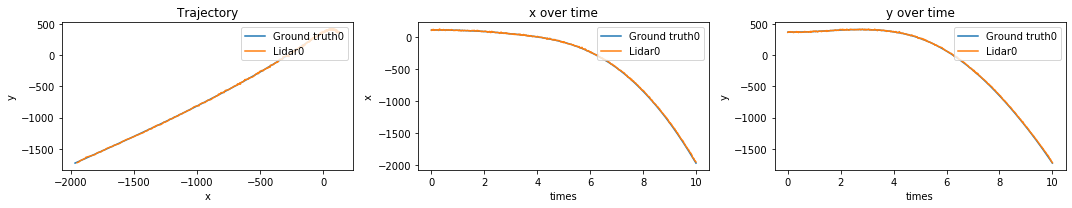

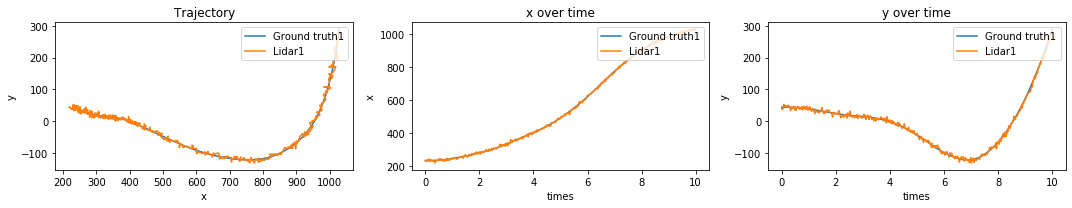

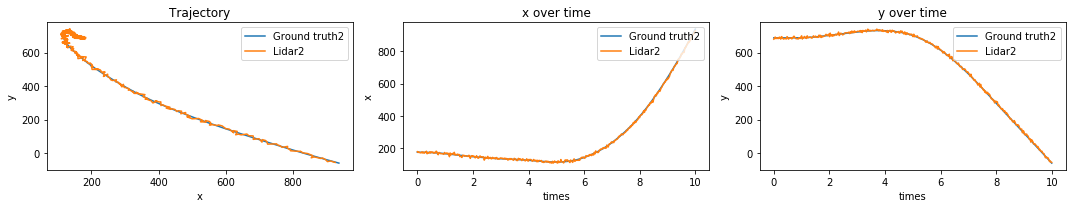

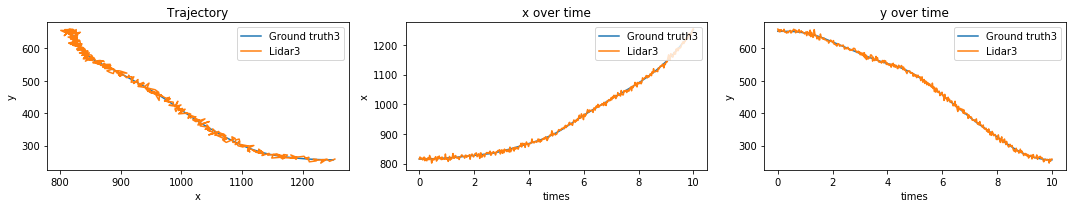

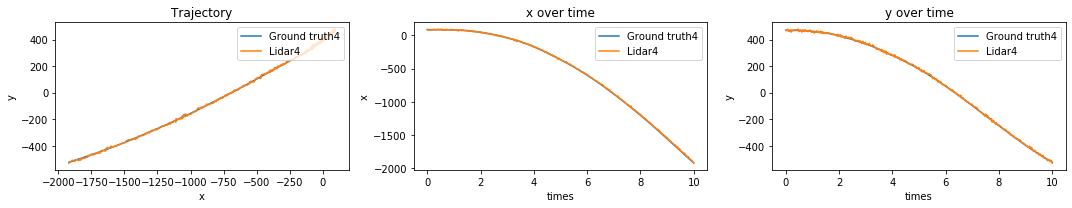

In [10]:
for Idx, lidar in enumerate(lidars):
    fig, axes = plt.subplots(1, 3, figsize = (15,3))
    objects[Idx].subplots(times, axes, Idx)
    lidar.subplots(timesLidar, axes, Idx)
    
    axes[0].legend(loc="upper right")
    axes[0].set(xlabel = 'x', ylabel = 'y')
    axes[0].set_title('Trajectory')

    axes[1].legend(loc="upper right")
    axes[1].set(xlabel = 'times', ylabel = 'x')
    axes[1].set_title('x over time')

    axes[2].legend(loc="upper right")
    axes[2].set(xlabel = 'times', ylabel = 'y')
    axes[2].set_title('y over time')
    
    plt.tight_layout()
    plt.show()

4


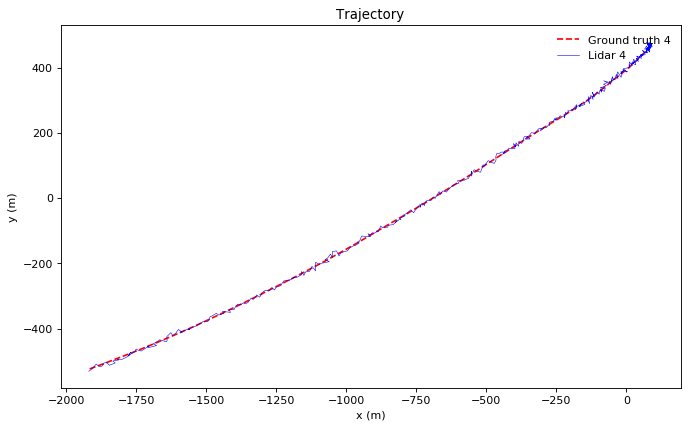

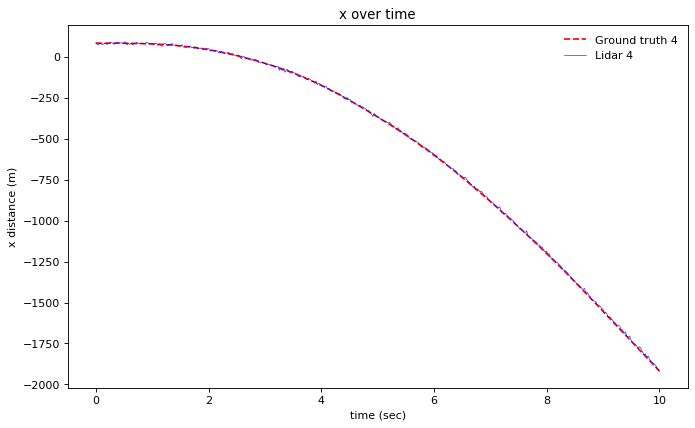

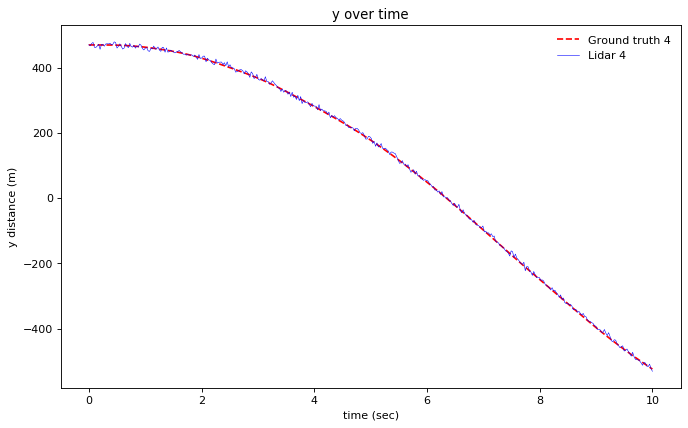

In [16]:
obj = int(input())

# Trajectory
plt.figure(figsize=(10,6), dpi=80)
plt.title("Trajectory")
objects[obj].plot (times, obj, TRAJECTORY)
lidars[obj].plot (timesLidar, obj, TRAJECTORY)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

# x over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("x over time")
objects[obj].plot (times, obj, X)
lidars[obj].plot (timesLidar, obj, X)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('x distance (m)')
plt.show()

# y over time
plt.figure(figsize=(10,6), dpi=80)
plt.title("y over time")
objects[obj].plot (times, obj, Y)
lidars[obj].plot (timesLidar, obj, Y)

plt.legend(loc='upper right', frameon=False)
plt.xlabel('time (sec)')
plt.ylabel('y distance (m)')
plt.show()